In [1]:
import pandas as pd
from IPython.display import Markdown

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput
from estival.model import BayesianCompartmentalModel
import estival.priors as esp
import estival.targets as est

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Base model construction
model = CompartmentalModel(
    times=[1850.0, 2024.0],
    compartments=["susceptible", "early latent", "late latent", "infectious", "recovered"],
    infectious_compartments=["infectious"],
)
model.set_initial_population({"susceptible": 1000.0, "infectious": 1.0})

In [3]:
# Add latency structures
latency_flows = [
    ("stabilisation", "early latent", "late latent"),
    ("early activation", "early latent", "infectious"),
    ("late activation", "late latent", "infectious"),
]
for flow, source, dest in latency_flows:
    model.add_transition_flow(flow, Parameter(f"{flow} rate"), source, dest)

In [4]:
# Add infection processes
infection_origins = ["susceptible", "late latent", "recovered"]
for origin in infection_origins:
    model.add_infection_frequency_flow(f"infection_from_{origin}", Parameter("contact rate"), origin, "early latent")

In [5]:
# Natural history flows
model.add_transition_flow("recovery", Parameter("recovery rate"), "infectious", "recovered")
# model.add_death_flow("TB death", Parameter("death rate"), "infectious")

In [6]:
# Track relevant outputs
for timing in ["early", "late"]:
    model.request_output_for_flow(f"{timing} activation", f"{timing} activation", save_results=False)
inc = model.request_function_output("incidence", DerivedOutput("early activation") + DerivedOutput("late activation"))
model.request_function_output("notifications", inc * Parameter("case detection rate"));

In [7]:
# Parameters
params = {
    "contact rate": 3.0,
    "stabilisation rate": 1.0,
    "early activation rate": 1.0,
    "late activation rate": 1.0,
    "case detection rate": 1.0,
    "recovery rate": 1.0,
    "death rate": 1.0,
}
param_units = {
    "contact rate": "per day",
    "stabilisation rate": "per day",
    "early activation rate": "per day",
    "late activation rate": "per day",
    "case detection rate": "",
    "recovery rate": "per day",
    "death rate": "per day",
}
fixed_param_table = pd.DataFrame({"values": params, "units": param_units})

In [8]:
Markdown(fixed_param_table.to_markdown())

|                       |   values | units   |
|:----------------------|---------:|:--------|
| contact rate          |        3 | per day |
| stabilisation rate    |        1 | per day |
| early activation rate |        1 | per day |
| late activation rate  |        1 | per day |
| case detection rate   |        1 |         |
| recovery rate         |        1 | per day |
| death rate            |        1 | per day |

In [9]:
model.run(params)
priors = [esp.UniformPrior("contact rate", (0.02, 0.15))]
dummy_target = pd.Series({1900.0: 200.0, 1910.0: 210})
targets = [est.NormalTarget("notifications", dummy_target, 20.0)]
bcm = BayesianCompartmentalModel(model, params, priors, targets)

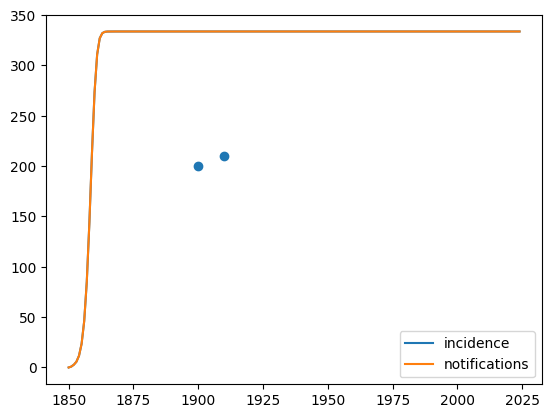

In [12]:
plot = model.get_derived_outputs_df().plot()
plot.scatter(dummy_target.index, dummy_target)

In [11]:
model.flows

[<TransitionFlow 'stabilisation' from early latent to late latent>,
 <TransitionFlow 'early activation' from early latent to infectious>,
 <TransitionFlow 'late activation' from late latent to infectious>,
 <InfectionFrequencyFlow 'infection_from_susceptible' from susceptible to early latent>,
 <InfectionFrequencyFlow 'infection_from_late latent' from late latent to early latent>,
 <InfectionFrequencyFlow 'infection_from_recovered' from recovered to early latent>,
 <TransitionFlow 'recovery' from infectious to recovered>]